In [107]:
from sympy import symbols
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt

In [108]:
a_1 = 0.0134
b_1 = 1
c_1 = 4.35 * 10e-4
m_1 = 1
alpha_0 = 1.94 * 10e-2
delta = 1.5 * 10e3
gamma = 0.2 * 10e-2
l = 10
T_0 = 300
R = 0.5
F_0 = 50
X = sp.Symbol('x')
T = sp.Function('T')(X)
y_i_prev, y_i, y_i_next = symbols('y_{i-1}, y_i, y_{i+1}')

In [109]:
alpha = alpha_0 * (y_i / delta - 1) ** 4 + gamma
p = 2 / R * alpha
f = 2 * T_0 / R * alpha
k = a_1 * (b_1 + c_1 * y_i ** m_1)
k_prev = k.subs(y_i, y_i_prev)
k_next = k.subs(y_i, y_i_next)
# F = - k * sp.diff(T, X)

In [110]:
alpha, p, f, k

(0.194*(6.66666666666667e-5*y_i - 1)**4 + 0.02,
 0.776*(6.66666666666667e-5*y_i - 1)**4 + 0.08,
 232.8*(6.66666666666667e-5*y_i - 1)**4 + 24.0,
 5.829e-5*y_i + 0.0134)

In [111]:
k_prev

5.829e-5*y_{i-1} + 0.0134

In [112]:
n = 100
h = l / n
x = np.linspace(0, l, n+1, endpoint=True)
y = np.full_like(x, T_0)

In [113]:
def eval_sp(func, i):
    func = func.subs(y_i, y[i]).subs(y_i_prev, y[i-1])
    if i < n:
        func = func.subs(y_i_next, y[i+1])
    return func

In [114]:
def get_a_i(i):
    if i == 0:
        return sp.Float(0)
    return (k_prev + k) / 2

def get_b_i(i):
    if i == 0:
        return (k + k_next) / 2
    if i == n:
        return (k_prev + k) / 2 + p * h ** 2 + alpha * h
    return (k_prev + k) / 2 + (k + k_next) / 2 + p * h ** 2

def get_c_i(i):
    if i == 0:
        return (k + k_next) / 2
    if i == n:
        return sp.Float(0)
    return (k + k_next) / 2

def get_d_i(i):
    if i == 0:
        return f * h ** 2 + F_0 * h
    if i == n:
        return f * h ** 2 + alpha * T_0 * h
    return f * h ** 2

In [115]:
A_prime = np.zeros_like(x)
B_prime = np.zeros_like(x)
C_prime = np.zeros_like(x)
D_prime = np.zeros_like(x)

In [121]:
for i, x_i in enumerate(x):
    A_i = get_a_i(i)
    B_i = get_b_i(i)
    C_i = get_c_i(i)
    D_i = get_d_i(i)

    G_i = A_i * y_i_prev + B_i * y_i - C_i * y_i_next + D_i

    A_prime[i] = eval_sp(sp.diff(G_i, y_i_prev), i)
    B_prime[i] = -eval_sp(sp.diff(G_i, y_i), i)
    C_prime[i] = eval_sp(sp.diff(G_i, y_i_next), i)
    D_prime[i] = eval_sp(G_i, i)
    # посмотреть производные, можешь частные всякие посмотреть
    print(sp.diff(G_i, y_i_next))

eta = np.zeros_like(x)
xi = np.zeros_like(x)
delta_y = np.zeros_like(x)

for i in range(1, n+1):
    xi[i] = C_prime[i-1] / (B_prime[i-1] - A_prime[i-1] * xi[i-1])
    eta[i] = (A_prime[i-1] * eta[-1] + D_prime[i-1]) / (B_prime[i-1] - A_prime[i-1] * xi[i-1])

for i in reversed(range(1, n+1)):
    if i == n:
        delta_y[i] = (A_prime[n] * eta[n] + D_prime[n]) / (B_prime[n] - A_prime[n] * xi[n])
    else:
        delta_y[i] = xi[i+1] * delta_y[i+1] + eta[i+1]

-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-5.829e-5*y_{i+1} - 0.0134
-

In [117]:
y_final = np.zeros_like(x)
y_final[0] = F_0
for i in range(1, n):
    y_final[i] = y_final[i-1] + delta_y[i]

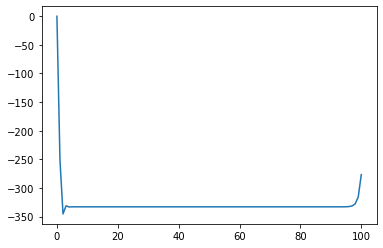

In [118]:
plt.plot(delta_y)

In [119]:
delta_y

array([   0.        , -251.01341656, -345.4401456 , -331.25579367,
       -333.33192643, -333.02686192, -333.0716622 , -333.0650825 ,
       -333.06604883, -333.06590691, -333.06592775, -333.06592469,
       -333.06592514, -333.06592507, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592508,
       -333.06592508, -333.06592508, -333.06592508, -333.06592

In [120]:
F_0

50